# A study of behaiviour of the Sinkhorn algorithm for permutation matrices

In [1]:
import sys
import typing as th
sys.path.append("..")  # add parent directory to path
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm
from collections import defaultdict
from ocd.models.permutation.module import LearnablePermutation

num_features = 6
sinkhorn_num_iters = 50  # default number of iterations
sinkhorn_temp = .1  # default temperature
gumbel_noise_std = 1.0  # default standard deviation of the Gumbel noise
num_samples = 2000  # number of samples to draw for evaluation
threshold = 1e-2

/Users/vahidzee/.pyenv/versions/3.10.9/envs/ocd/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Double Stochasticity of Results <small>(threshold 1e-5)</small>

In [2]:
def plot_line(
    x,
    y,
    ax,
    label: th.Optional[str] = None,
    xlabel: th.Optional[str] = None,
    ylabel: th.Optional[str] = None,
    title: th.Optional[str] = None,
    mark_first: th.Optional[float] = None,
):
    # set y-axis to 0. to 1.1
    ax.set_ylim(0.0, 1.1)
    sns.lineplot(x=x, y=y, ax=ax, label=label)
    if mark_first:
        # find the first x with specified value
        first = x[torch.tensor(y) == mark_first][0].item()
        # draw a vertical line at the first number of iterations that yields 100% double stochasticity
        ax.axvline(x=first, color="red", linestyle="--")
        # set label for the vertical line
        ax.text(
            first + x.max() * 0.01,
            0.5,
            f"at {first:.2f}",
            rotation=90,
            verticalalignment="center",
            horizontalalignment="left",
        )
    ax.grid(True)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)


100%|██████████| 12/12 [01:10<00:00,  5.84s/it]


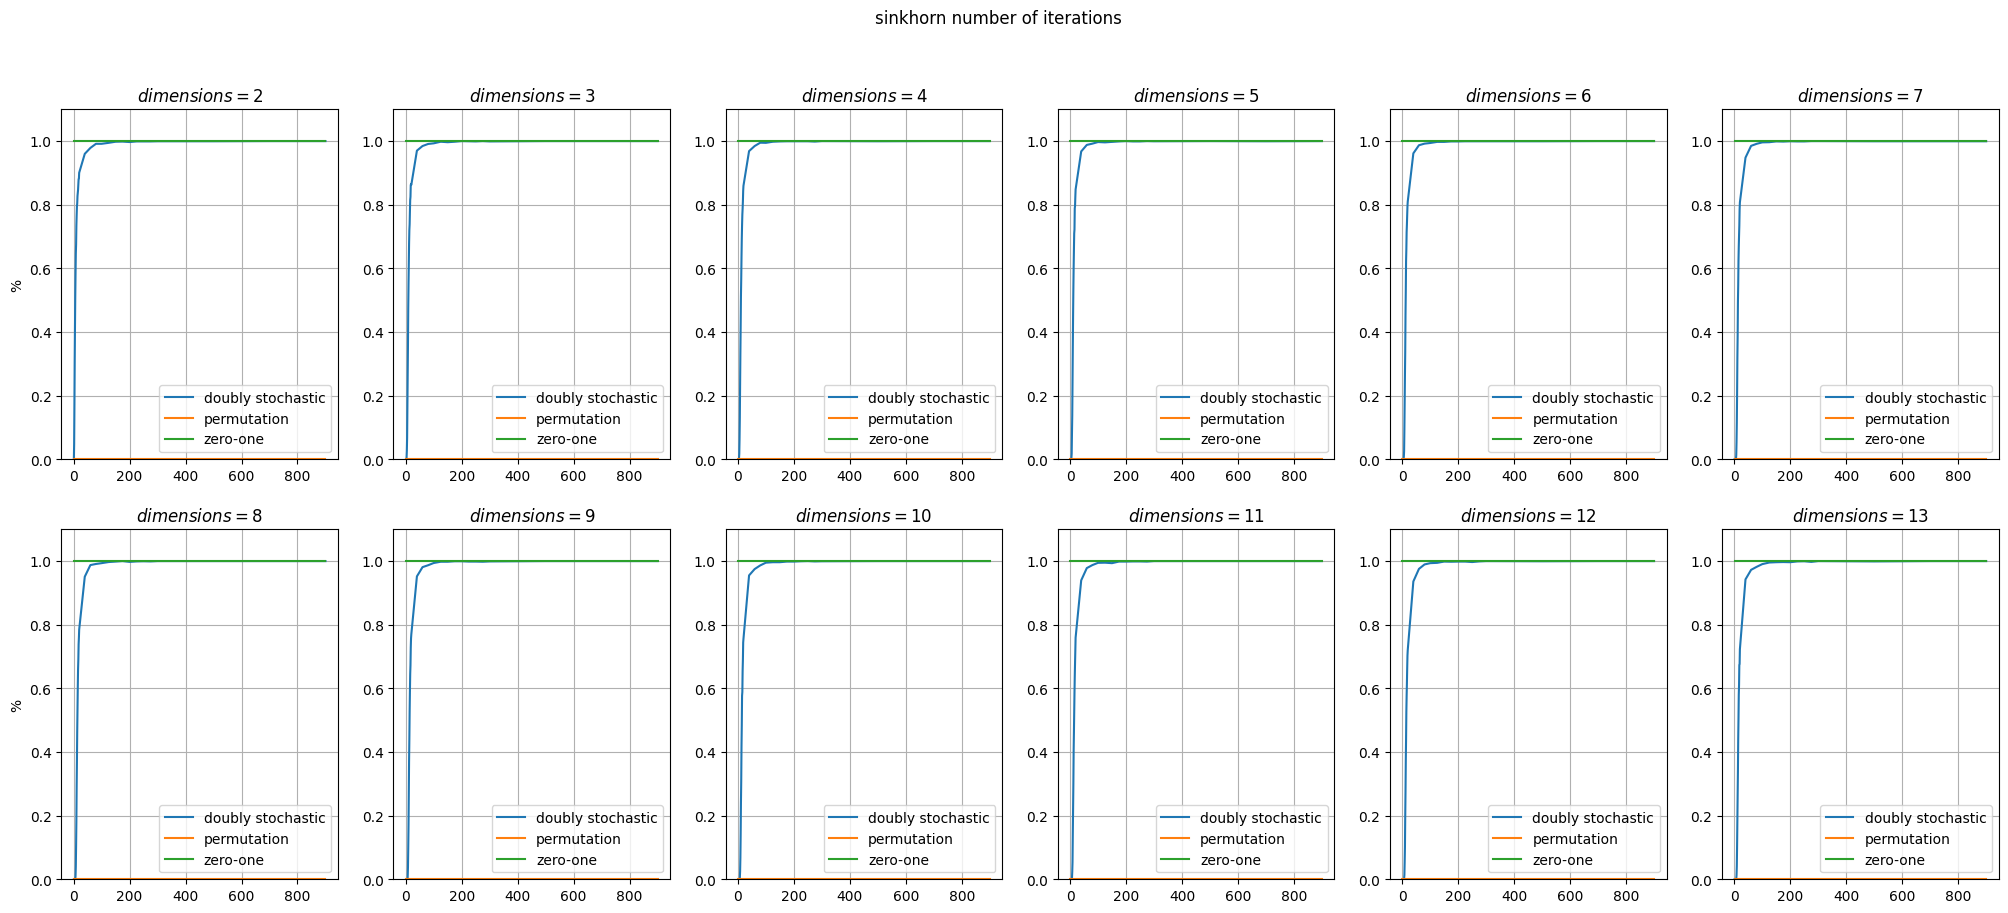

In [3]:
# study the effect of number of iterations (from 1 to 5000)
num_iters = torch.cat(
    [torch.arange(1, 20), torch.arange(20, 100, 20), torch.arange(100, 300, 25), torch.arange(300, 1000, 200)]
)

# create a grid of plots for num_features from 2 to 13
fig, axes = plt.subplots(2, 6, figsize=(25, 10))
fig.suptitle(r"sinkhorn number of iterations")
for i in tqdm(range(1, 13)):
    # create a learnable permutation
    perm_model = LearnablePermutation(num_features=i + 1)

    # evaluate the model across grid
    results = defaultdict(list)
    for n in num_iters:
        eval_results = perm_model.evaluate_permutations(
            # parameters
            sinkhorn_num_iters=n,
            sinkhorn_temp=sinkhorn_temp,
            threshold=threshold,
            num_samples=num_samples,
            gumbel_noise_std=gumbel_noise_std,
            # evaluation results
            reduce=True,
        )
        for k, v in eval_results.items():
            results[k].append(v.item())
    # plot the change in double stochasticity
    ax = axes[(i - 1) // 6, (i - 1) % 6]
    plot_line(
        x=num_iters,
        y=results["is_doubly_stochastic"],
        label="doubly stochastic",
        ax=ax,
        ylabel=r"%" if (i - 1) % 6 == 0 else None,
        title=f"$dimensions={i+1}$",
    )
    sns.lineplot(x=num_iters, y=results["is_permutation"], ax=ax, label="permutation")
    sns.lineplot(x=num_iters, y=results["is_between_zero_one"], ax=ax, label="zero-one")


100%|██████████| 12/12 [00:23<00:00,  1.97s/it]


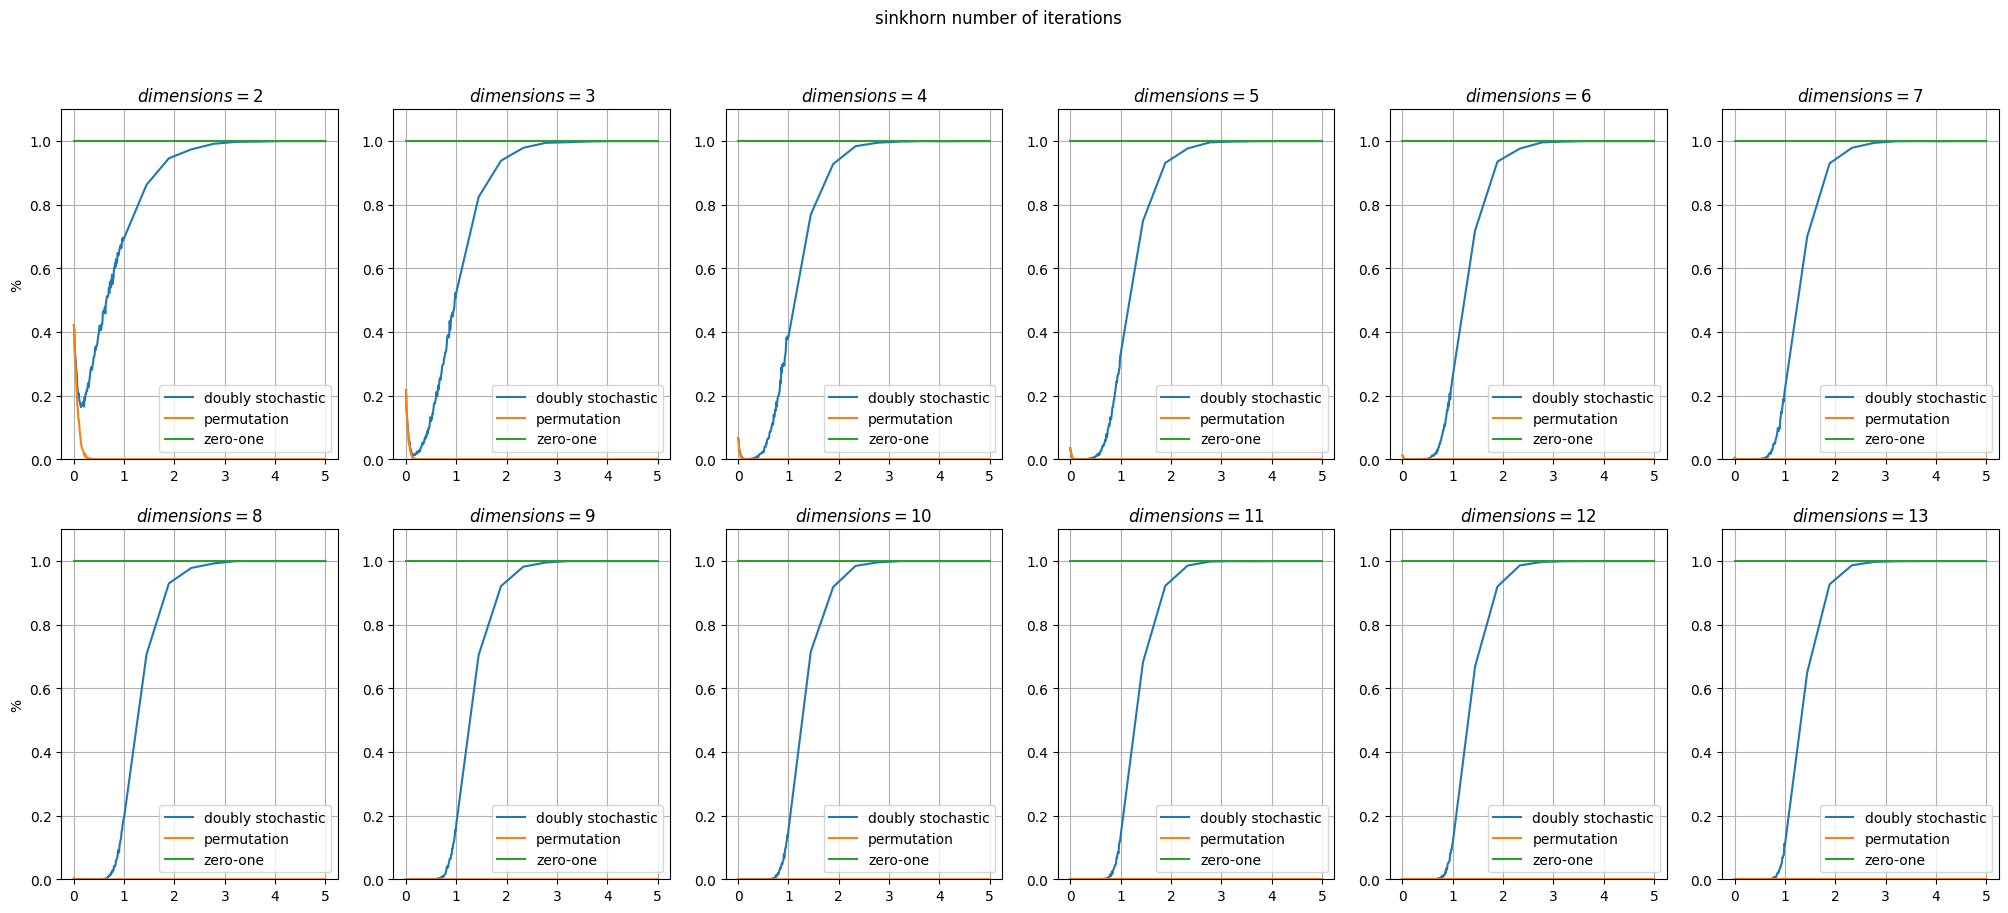

In [4]:
# study the effect of temperature (from 0.01 to 10)
temperatures = torch.cat([torch.linspace(0.001, 1, 100), torch.linspace(1, 5, 10)])

# create a grid of plots for num_features from 2 to 13
fig, axes = plt.subplots(2, 6, figsize=(25, 10))
fig.suptitle(r"sinkhorn number of iterations")
for i in tqdm(range(1, 13)):
    # create a learnable permutation
    perm_model = LearnablePermutation(num_features=i + 1)

    # evaluate the model across grid
    results = defaultdict(list)
    for t in temperatures:
        eval_results = perm_model.evaluate_permutations(
            # parameters
            sinkhorn_num_iters=sinkhorn_num_iters,
            sinkhorn_temp=t,
            threshold=threshold,
            num_samples=num_samples,
            gumbel_noise_std=gumbel_noise_std,
            # evaluation results
            reduce=True,
        )
        for k, v in eval_results.items():
            if k.startswith("is"):
                results[k].append(v.item())

    # plot the change in double stochasticity
    ax = axes[(i - 1) // 6, (i - 1) % 6]
    plot_line(
        x=temperatures,
        y=results["is_doubly_stochastic"],
        label="doubly stochastic",
        ax=ax,
        ylabel=r"%" if (i - 1) % 6 == 0 else None,
        title=f"$dimensions={i+1}$",
    )
    sns.lineplot(x=temperatures, y=results["is_permutation"], ax=ax, label="permutation")
    sns.lineplot(x=temperatures, y=results["is_between_zero_one"], ax=ax, label="zero-one")


 33%|███▎      | 4/12 [00:39<01:19,  9.99s/it]


KeyboardInterrupt: 

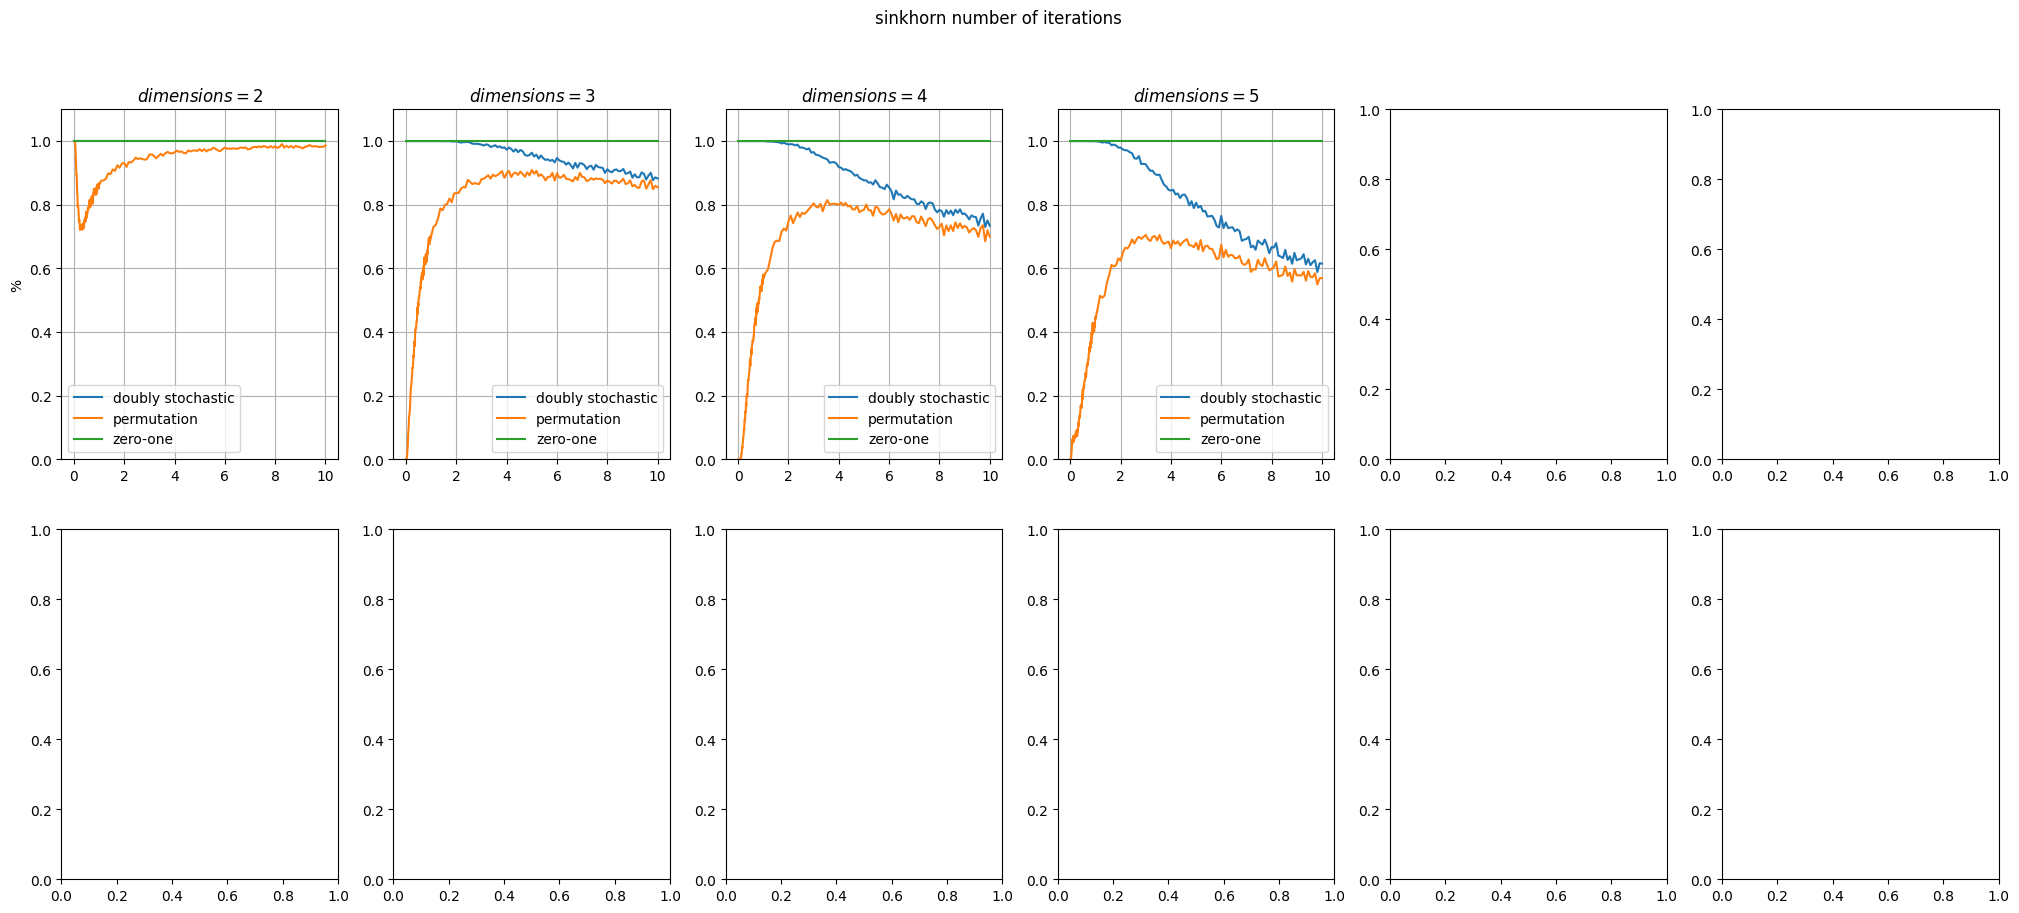

In [4]:
# study the effect of Gumbel noise standard deviation (from 0.0001 to 10)
gumbel_noise_stds = torch.cat([torch.linspace(0.0001, 1, 100), torch.linspace(1, 10, 100)])
threshold=0.1
# create a grid of plots for num_features from 2 to 13
fig, axes = plt.subplots(2, 6, figsize=(25, 10))
fig.suptitle(r"sinkhorn number of iterations")
for i in tqdm(range(1, 13)):
    # create a learnable permutation
    perm_model = LearnablePermutation(num_features=i + 1)

    # evaluate the model across grid
    results = defaultdict(list)
    for std in gumbel_noise_stds:
        eval_results = perm_model.evaluate_permutations(
            # parameters
            sinkhorn_num_iters=sinkhorn_num_iters,
            sinkhorn_temp=sinkhorn_temp,
            threshold=threshold,
            num_samples=num_samples,
            gumbel_noise_std=std,
            # evaluation results
            reduce=True,
        )
        for k, v in eval_results.items():
            if k.startswith("is"):
                results[k].append(v.item())

    # plot the change in double stochasticity
    ax = axes[(i - 1) // 6, (i - 1) % 6]
    plot_line(
        x=gumbel_noise_stds,
        y=results["is_doubly_stochastic"],
        label="doubly stochastic",
        ax=ax,
        ylabel=r"%" if (i - 1) % 6 == 0 else None,
        title=f"$dimensions={i+1}$",
    )
    sns.lineplot(x=gumbel_noise_stds, y=results["is_permutation"], ax=ax, label="permutation")
    sns.lineplot(x=gumbel_noise_stds, y=results["is_between_zero_one"], ax=ax, label="zero-one")